# Calcul prévisionnel

In [1]:
########## PARAMETRAGE #########
CT_CJ = 5
#True pour le score actuel
#False pour le score d'il y a 12 mois
CT_NEW_SCORE = True
# Colonnes à ne pas utiliser pour les calculs
dropcols = ['procol', 'msoScore', 'siren', 'indiScore', 'encours', # Correspond à la target, on vire
#            'indiScoreMoins1', 'indiScoreMoins2', 'indiScoreMoins3', 'indiScoreMoins4', # Pour enlever son influence
#            'encoursMoins1', 'encoursMoins2', 'encoursMoins3', 'encoursMoins4', # Pour enlever son influence
#            'procolMoins1', 'procolMoins2', 'procolMoins3', 'procolMoins4' # Pour enlever son influence
           ]
########## PARAMETRAGE #########

## Récupération des données du modèle

In [2]:
import pandas as pd
import numpy as np
import time

from score_functions import *

In [3]:
# Utilisation du modèle enregistré
myModel = load_sklearn_obj('CJ' + str(CT_CJ) + '_RandomForestClassifier_ok')
myModel

CJ5_RandomForestClassifier_ok loaded


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [4]:
# Utilisation du scaler enregistré
myScaler = load_sklearn_obj('CJ' + str(CT_CJ) + '_model_scaler_ok')
myScaler

CJ5_model_scaler_ok loaded


StandardScaler(copy=True, with_mean=True, with_std=True)

## Chargement et préparation des data

In [5]:
df = loadTableCJ(CT_CJ, verbose=False)

*** loadTableCJ ***
reading C:/Users/Mscao/OneDrive - INTESCIA/Export/scores_predictions_PROD_CJ5.csv ...
*** complete_and_clean ***
Suppression des bilans financiers...
reading C:/Users/Mscao/OneDrive - INTESCIA/Export/stats_5_ans_PROD_CJ5.csv ...
2453107 SIREN au total
-1258498 sans indiScore il y a 12 mois, ou à 0
-50763 absorptions
Reste 1143846 SIREN
*** fillBlanks ***
	Nan de ii_ORIGINE remplacés par 1
	Nan de ii_EXPLET remplacés par O
	Nan de indiScoreMoins2 remplacés par 10.300353459032637
	Nan de indiScoreMoins3 remplacés par 10.277438226944739
	Nan de indiScoreMoins4 remplacés par 10.553874382237959
	Nan de ii_ORIGINE remplacés par 0
	Nan de ii_EXPLET remplacés par 0
	Nan de sb_EnBourse remplacés par 0
	Nan de encoursMoins1 remplacés par 0
	Nan de encoursMoins2 remplacés par 0
	Nan de encoursMoins3 remplacés par 0
	Nan de encoursMoins4 remplacés par 0


In [6]:
# Pour l'année en cours on décale tout
if CT_NEW_SCORE:
    newScore = 'mso2018'
    
    df['encoursMoins4'] = df['encoursMoins3']
    df['encoursMoins3'] = df['encoursMoins2']
    df['encoursMoins2'] = df['encoursMoins1']
    df['encoursMoins1'] = df['encours']

    df['indiScoreMoins4'] = df['indiScoreMoins3']
    df['indiScoreMoins3'] = df['indiScoreMoins2']
    df['indiScoreMoins2'] = df['indiScoreMoins1']
    df['indiScoreMoins1'] = df['indiScore']

    df['procolMoins4'] = df['procolMoins3']
    df['procolMoins3'] = df['procolMoins2']
    df['procolMoins2'] = df['procolMoins1']
    df['procolMoins1'] = df['procol']
else:
    newScore = 'mso2017'


## Prédiction à l'aide du modèle

In [7]:
from pandas.api.types import CategoricalDtype

def TestModel(p_df, p_dropcols):

    # On enlève la target des data bien sûr
    X = DropCol(p_df, 'target')
    # Ainsi que les colonnes non désirées
    for col in p_dropcols:
        # Sauf le score d'il y a 1 an, on s'en occupe plus loin
        if col == 'indiScoreMoins1': continue
        X = DropCol(X, col)

    scalingDFcols = []
    categDFcols = []
    for col in X.columns:
        if (X[col].dtype == object) or (X[col].dtype == np.str):
            categDFcols.append(col)
        else:
            scalingDFcols.append(col)

    # Chargement de la liste des catégories possibles
    for col in categDFcols:
        lst = load_obj('CJ' + str(CT_CJ) + '_column_' + col)
        X[col] = X[col].astype(CategoricalDtype(categories=lst))

    categDF = X[categDFcols]
    scalingDF = X[scalingDFcols]
    
    # Binarisation en dummies pour garder la maitrise des noms des colonnes
    categDF_encoded = pd.get_dummies(categDF)
    print('Après binarisation les catégories prennent', categDF_encoded.shape[1], 'dimensions.')

    # Concaténation
    x_final = pd.concat([scalingDF, categDF_encoded], axis=1)
    # Seules les xnum premières colonnes sont numériques
    xnum = scalingDF.shape[1]
    x_final_numerical = x_final.iloc[:, 0:xnum]

    x_final_numerical = myScaler.transform(x_final_numerical)
    x_final = x_final.copy()
    x_final.loc[:, 0:xnum] = x_final_numerical
    
    y_pred = myModel.predict_proba(x_final)

    print('Done!')
    return y_pred

In [8]:
result = TestModel(df, dropcols)
result

CJ5_column_ii_ACTIVNAT loaded
CJ5_column_ii_ORIGINE loaded
CJ5_column_ii_MODET loaded
CJ5_column_ii_EXPLET loaded
CJ5_column_ii_CJ loaded
CJ5_column_ii_TEFF_ENT loaded
CJ5_column_ii_ADR_DEP loaded
CJ5_column_ii_TCA loaded
CJ5_column_ii_TCAEXP loaded
CJ5_column_ii_NAF1 loaded
CJ5_column_procolMoins1 loaded
CJ5_column_procolMoins2 loaded
CJ5_column_procolMoins3 loaded
CJ5_column_procolMoins4 loaded
Après binarisation les catégories prennent 302 dimensions.
Done!


array([[0.03, 0.97],
       [0.02, 0.98],
       [0.04, 0.95],
       ...,
       [0.01, 0.99],
       [0.01, 0.99],
       [0.01, 0.99]])

In [12]:
# Intégration du nouveau score dans le dataframe original
newScoreRounded = newScore + '_rounded'
df[newScore] = [w for w in result[:, 1]]
df[newScoreRounded] = [np.round(w*20) for w in result[:, 1]]

mso2017_round
0.0       9447
1.0       4475
2.0       2841
3.0       2012
4.0       1723
5.0       1876
6.0       2436
7.0       3464
8.0       5849
9.0       9438
10.0      9565
11.0      5571
12.0      2957
13.0      2598
14.0      3138
15.0      4396
16.0      8143
17.0     16264
18.0     47988
19.0    229333
20.0    770332
Name: mso2017_round, dtype: int64

### Distribution du nouveau score

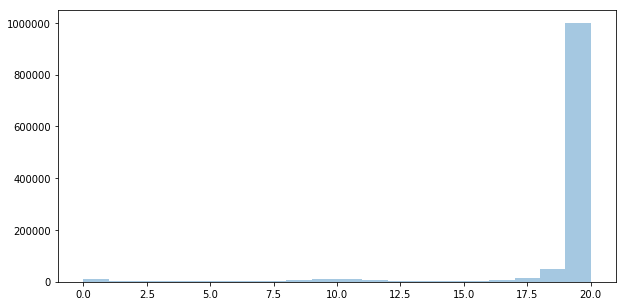

In [9]:
# Distribution du nouveau score
plt.figure(figsize=(10, 5))
sns.distplot(np.round(result[:, 1]*20), bins=range(21), kde=False)

In [ ]:
df.groupby([newScoreRounded])[newScoreRounded].count()

### Distribution de l'ancien score

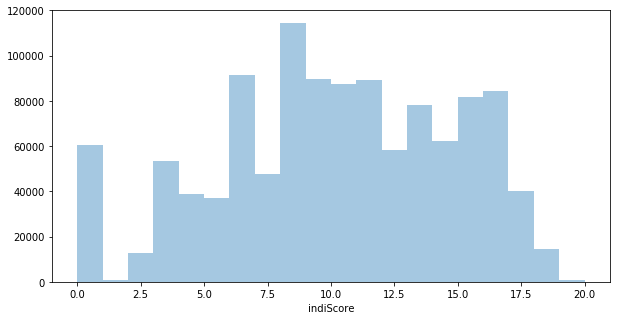

In [10]:
# Distribution de l'ancien score
plt.figure(figsize=(10, 5))
sns.distplot(df['indiScore'], bins=range(21), kde=False)

In [11]:
df.groupby(['indiScore'])['indiScore'].count()

indiScore
0      60456
1        846
2      12668
3      53348
4      38689
5      37248
6      91236
7      47881
8     114472
9      89881
10     87678
11     89440
12     58160
13     78107
14     62093
15     81820
16     84545
17     40091
18     14505
19       682
Name: indiScore, dtype: int64

### Affichage des SIREN en défaut

In [13]:
df[['siren', 'indiScoreMoins1', 'indiScore', newScore, newScoreRounded, 'target']][df.target==False]

,indiScore,indiScoreMoins1,mso2017,mso2017_round,target
4,0,6.0,0.115000,2.0,False
8,8,8.0,0.047500,1.0,False
86,8,8.0,0.233333,5.0,False
89,11,11.0,0.482333,10.0,False
190,0,5.0,0.248286,5.0,False
244,0,3.0,0.147500,3.0,False
313,0,12.0,0.030000,1.0,False
347,11,12.0,0.474833,9.0,False
554,7,6.0,0.088333,2.0,False
636,2,4.0,0.122143,2.0,False


In [14]:
df[['siren', 'indiScoreMoins1', 'indiScore', newScore, newScoreRounded, 'target']]

,siren,indiScoreMoins1,mso2017,mso2017_round,indiScore,target
1,5420120,9.0,0.969167,19.0,9,True
2,5450093,14.0,0.981000,20.0,11,True
3,5450119,3.0,0.955000,19.0,3,True
4,5480546,6.0,0.115000,2.0,0,False
5,5520028,12.0,0.996667,20.0,12,True
7,5520176,16.0,1.000000,20.0,16,True
8,5520242,8.0,0.047500,1.0,8,False
9,5520325,18.0,0.990000,20.0,18,True
10,5541552,11.0,0.981667,20.0,11,True
11,5580113,13.0,0.975833,20.0,11,True


In [20]:
df[['indiScore', 'indiScoreMoins1', newScore, newScoreRounded, 'target']].describe()

,indiScore,indiScoreMoins1,mso2017,mso2017_round
count,1.143846e+06,1.143846e+06,1.143846e+06,1.143846e+06
mean,9.715782e+00,9.799357e+00,9.399839e-01,1.886063e+01
std,4.605785e+00,3.959951e+00,1.600822e-01,3.234480e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,7.000000e+00,9.645000e-01,1.900000e+01
50%,1.000000e+01,1.000000e+01,9.875000e-01,2.000000e+01
75%,1.300000e+01,1.300000e+01,1.000000e+00,2.000000e+01
max,1.900000e+01,1.900000e+01,1.000000e+00,2.000000e+01


### Sauvegarde

In [16]:
if CT_NEW_SCORE:
    save_obj(df[['siren', 'indiScoreMoins1', 'indiScore', newScore, newScoreRounded]], 'result2018')
else:
    save_obj(df[['siren', 'indiScoreMoins1', 'indiScore', newScore, newScoreRounded, 'target']], 'result2017')

C:/Users/Mscao/Google Drive/Jupyter/GIT/Projet8/save/result2017.pkl saved


In [17]:
load_obj('result2017')

result2017 loaded


,siren,indiScoreMoins1,indiScore,mso2017,mso2017_round,target
1,5420120,9.0,9,0.969167,19.0,True
2,5450093,14.0,11,0.981000,20.0,True
3,5450119,3.0,3,0.955000,19.0,True
4,5480546,6.0,0,0.115000,2.0,False
5,5520028,12.0,12,0.996667,20.0,True
7,5520176,16.0,16,1.000000,20.0,True
8,5520242,8.0,8,0.047500,1.0,False
9,5520325,18.0,18,0.990000,20.0,True
10,5541552,11.0,11,0.981667,20.0,True
11,5580113,13.0,11,0.975833,20.0,True


In [18]:
load_obj('result2018')

result2018 loaded


,siren,indiScoreMoins1,indiScore,mso2018,mso2018_round
1,5420120,9,9,0.971667,19.0
2,5450093,11,11,0.976667,20.0
3,5450119,3,3,0.955000,19.0
4,5480546,0,0,0.378333,8.0
5,5520028,12,12,0.996667,20.0
7,5520176,16,16,1.000000,20.0
8,5520242,8,8,0.212000,4.0
9,5520325,18,18,0.990000,20.0
10,5541552,11,11,0.973333,19.0
11,5580113,11,11,0.952500,19.0
